In [1]:
import torch
import torch.nn as nn

        
patch_dim = 16
dim = 224
seq_len = (dim**2 // patch_dim**2)
print(f"Seq len: {seq_len}")
input_channels = 3
hidden_dim = 768
class_token = nn.Parameter(torch.randn((1, 1, hidden_dim)))
x = torch.randn((2, 3, dim, dim))

x.view(x.shape[0], seq_len, x.shape[1]*patch_dim**2).shape

Seq len: 196


torch.Size([2, 196, 768])

In [2]:
a = torch.randn((2, 12, 16))
b = torch.randn((1, 1, 16))
print(b.repeat(2, 1, 1).shape)
print(torch.concat([a, b.repeat(2, 1, 1)], dim=1).shape)

torch.Size([2, 1, 16])
torch.Size([2, 13, 16])


In [3]:
embedding = nn.Conv2d(in_channels=input_channels, out_channels=hidden_dim,
                        kernel_size=patch_dim, stride=patch_dim)
# we use broadcasting here, embedding output is [batch, seq_len, hidden_dim]
positional_embeds = nn.Parameter(torch.zeros((seq_len + 1, hidden_dim)))

out = embedding(x)
print(out.shape)
out = out.view(out.shape[0], out.shape[1], -1)
print(out.shape)
out = out.transpose(1, 2)
print(out.shape)
# [B, N, D] and [1, 1, D]
out = torch.concat([class_token.repeat(2, 1, 1), out], dim=1)
print(out.shape)

out += positional_embeds
print(out.shape)

torch.Size([2, 768, 14, 14])
torch.Size([2, 768, 196])
torch.Size([2, 196, 768])
torch.Size([2, 197, 768])
torch.Size([2, 197, 768])


In [4]:
num_heads = 12
head_dim = hidden_dim//num_heads
q = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False)
k = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False)
v = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False)
projection = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False)
attention_mask = None

B, N, D = out.shape

query = q(out)
key = k(out)
value = v(out)
print(query.shape, key.shape, value.shape)

# apply multi head, we want [B, num_heads, N, head_dim]
query = query.view(B, N, num_heads, head_dim).transpose(1, 2)
key = key.view(B, N, num_heads, head_dim).transpose(1, 2)
value = value.view(B, N, num_heads, head_dim).transpose(1, 2)
print(query.shape, key.shape, value.shape)

attention = torch.matmul(query, key.transpose(2, 3)) * hidden_dim**(-2)
print(attention.shape)
if attention_mask != None:
    attention += attention_mask
attention_weights = nn.functional.softmax(attention, dim=-1)

out_mhsa = torch.matmul(attention_weights, value)
print(out_mhsa.shape)

# now we need to go back to the normal shape
out_mhsa = out_mhsa.transpose(1, 2).contiguous().view(B, N, -1)
print(out_mhsa.shape)
out_mhsa = projection(out_mhsa)
print(out_mhsa.shape)


torch.Size([2, 197, 768]) torch.Size([2, 197, 768]) torch.Size([2, 197, 768])
torch.Size([2, 12, 197, 64]) torch.Size([2, 12, 197, 64]) torch.Size([2, 12, 197, 64])
torch.Size([2, 12, 197, 197])
torch.Size([2, 12, 197, 64])
torch.Size([2, 197, 768])
torch.Size([2, 197, 768])


In [5]:
gamma = nn.Parameter(torch.ones(hidden_dim))
beta = nn.Parameter(torch.zeros(hidden_dim))
eps = 1e-5

mean = out.mean(1, keepdim=True)
# we need the variance, not the standard deviation
var = out.var(1, keepdim=True)
print(mean.shape, var.shape)
out_ln = (out-mean) / torch.sqrt(var+eps)
out_ln = out_ln * gamma + beta
print(out_ln.shape)

torch.Size([2, 1, 768]) torch.Size([2, 1, 768])
torch.Size([2, 197, 768])


In [6]:
print(out_ln[0, :].mean(), out_ln[0, :].std())
print(out_ln[:, 0].mean(), out_ln[:, 0].std())

tensor(-1.6389e-10, grad_fn=<MeanBackward0>) tensor(0.9974, grad_fn=<StdBackward0>)
tensor(-0.0486, grad_fn=<MeanBackward0>) tensor(1.7142, grad_fn=<StdBackward0>)


In [7]:
ff_dim = 3072
projection_in = nn.Linear(in_features=hidden_dim, out_features=ff_dim, bias=True)
projection_out = nn.Linear(in_features=ff_dim, out_features=hidden_dim, bias=True)
activation = nn.GELU()

dropout = nn.Dropout(p=0.1)

out_mlp = dropout(activation(projection_in(out_ln)))
print(out_mlp.shape)
out_mlp = dropout(activation(projection_out(out_mlp)))
print(out_mlp.shape)

torch.Size([2, 197, 3072])
torch.Size([2, 197, 768])


In [8]:
device = "cuda"
a = torch.randn((512, 3, 512, 512)).to(device)

def check_memory(x: torch.tensor):
    x[1] = 0
    print(torch.cuda.max_memory_allocated())
    return x
b = check_memory(a)
print((a.data_ptr==b.data_ptr))
print(torch.allclose(a, b))
print(torch.cuda.max_memory_allocated())

1610612736
True
True
8053063680


In [11]:
b[1], a[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.,

# Data

In [1]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.transforms import v2
import random
from torchvision import tv_tensors
import omegaconf
import numpy as np
from torch.utils.data import default_collate
import glob
import omegaconf
path = "config.yaml"
conf = omegaconf.OmegaConf.load(path)


#乱数のシードを設定
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)


In [36]:
class ImageDataset(Dataset):
    def __init__(self, img_list:list[str], labels_dict: dict[str, int]):
        # as the names are in order we can just use listdir
        self.img_list = img_list
        self.labels_dict = labels_dict
        
    @staticmethod
    def load_image(img_path:str, resize:bool=False):
        img = Image.open(img_path)
        if resize:
            img = img.resize((224, 224))
        img_tensor = tv_tensors.Image(img) / 255.0
        
        return img_tensor
            
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        
        img = ImageDataset.load_image(img_path, True)
        label = os.path.basename(os.path.dirname(img_path))
        
        label = self.labels_dict[label]
        
        return img, label

In [41]:
class ImageTransform:
    def __init__(self, mean_img:list[float], std_img:list[float], size: int=224) -> None:
        self.mean_img = mean_img
        self.std_img = std_img
        # self.size = size
        
    def transform(self, image, phase:str="train"):
        if phase=="train":
            # top = random.randint(0, image.shape[-2]-self.size)
            # left = random.randint(0, image.shape[-1]-self.size)
            # image = v2.functional.resized_crop(inpt=image, top=top, left=left, height=image.shape[-2], width=image.shape[-1], size=self.size)

            # Random afine
            # rotation makes the validations loss diverge so set to 0
            degrees = 0
            translate = random.uniform(0, 0.15)
            # print(degrees, translate)
            image = v2.functional.affine(image, angle=degrees, translate=(translate, translate), scale=1.0, shear=0.0)

            # RandomHorizontalFlip 
            if random.random() > 0.5:
                image = v2.functional.horizontal_flip(image)

            # ElasticTransform
            displacement = v2.ElasticTransform(alpha=40.0)._get_params(image)['displacement']
            image = v2.functional.elastic(image, displacement)
            
            # adjust brightness and contrast
            brightness = random.uniform(0.92, 1.12)
            contrast = random.uniform(0.92, 1.12)
            image = v2.functional.adjust_brightness(image, brightness)
            image = v2.functional.adjust_contrast(image, contrast)

        # result of all the dataset
        image = v2.Normalize(mean=self.mean_img, std=self.std_img)(image)

        
        return image

        
    def __call__(self, img, phase:str="train"):
        return self.transform(img, phase)


In [4]:
# jpgのフォーマットしか使えない。
# リストにパスを格納
def make_datapath_list(base_dir):
    """
    データのパスを格納したリストを作成する
        
    Returns
    -------
    path_list : list
        データのパスを格納したリスト
    
    """
    target_path = os.path.join(base_dir+"/*.jpg")
    print(target_path)
    
    path_list = []
    #globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list
    
make_datapath_list('E:\\Data\\mobilenet\\images\\ayanami_rei')[0:10], len(make_datapath_list('E:\\Data\\mobilenet\\images\\ayanami_rei'))


E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ayanami_rei/*.jpg


(['E:\\Data\\mobilenet\\images\\ayanami_rei\\02556c9a75fcf7402f4c97d340922027d17a527c.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\02e8f8d0b8c776844d0c09fc961aef696c88d695.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0388564845bf7eb88c4f5f19f1651ad31131442f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\05c8d268052ceb0fee405086c9f063db1664a03e.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0894fb8b55b6c082d81582df62d74bf65f7946a1.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\093d277c20cf294e6235d965b3993c02ed9e416f.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0971091ad082dd8f2cd23fff4884944ddec6b2fc.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\09e7df7dd36e1f5a710547d96d284b4f2b1a5f61.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0b036ea70ddca109445b942883b4b9f8d9256e47.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0bf165f84028445bd83426b7b8edbe74a64dd808.jpg'],
 164)

In [5]:
# フォルダの画像数枚を数える
def get_filenames(img_dir):
    image_filenames = os.listdir(img_dir)
    image_filenames = [os.path.join(img_dir, img) for img in image_filenames]
    
    return image_filenames

# 訓練と検証を分割する
def split_train_val(base_dir, train_ration=0.9):
    
    train_paths = []
    val_paths = []
    # 最初はフォルダの名前を格納する
    folders_list = get_filenames(base_dir)
    
    for folder in folders_list:
        paths_list = make_datapath_list(folder)
        
        random.shuffle(paths_list)
        
        # 分割比率を使って
        total_samples = len(paths_list)
        train_samples = int(train_ration * total_samples)
        
        # リストを訓練データと検証データに分割
        train_data = paths_list[:train_samples]
        val_data = paths_list[train_samples:]
        
        train_paths.extend(train_data)
        val_paths.extend(val_data)
    
    return train_paths, val_paths

base_dir = "E:\Data\mobilenet\images"
train_list, val_list = split_train_val(base_dir)
len(train_list), len(val_list), val_list[0:10]


E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ikari_shinji/*.jpg
E:\Data\mobilenet\images\makinami_mari_illustrious/*.jpg
E:\Data\mobilenet\images\nagisa_kaworu/*.jpg
E:\Data\mobilenet\images\souryuu_asuka_langley/*.jpg


(703,
 81,
 ['E:\\Data\\mobilenet\\images\\ayanami_rei\\3da918fc112eb96399c34a5d054fc6f3463123df.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\bef5af783e7e31473a34f7f82c0f4d065fe7afc2.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\c82ad2bb311285f2183c3c4de815915a81c641f5.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\9335fe6aa36c590b0f92e04fa81bacfbdd27e508.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\efc70508626349852cc1faa8bfe146ec5d670d70.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\09e7df7dd36e1f5a710547d96d284b4f2b1a5f61.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\0894fb8b55b6c082d81582df62d74bf65f7946a1.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\657d758f3e51cd09bf84a0d8ec37380c494ca705.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\98f638e34bcdcdb40e302eba482579820c61d2c4.jpg',
  'E:\\Data\\mobilenet\\images\\ayanami_rei\\2ac4a879ef831091f6b1c7ee4416134a97c2ae0d.jpg'])

In [21]:
pilots_labels = {"ayanami_rei": 0, "ikari_shinji": 1, "makinami_mari_illustrious": 2,
                "nagisa_kaworu": 3, "souryuu_asuka_langley": 4}

data = ImageDataset(train_list, pilots_labels)

data[0][0].shape, data[0][1]

(torch.Size([3, 448, 448]), 0)

In [42]:
def collate_fn(
    batch: list[np.ndarray, int],
    device: torch.device,
    transform: callable=None,
    phase: str="train") -> tuple[torch.Tensor]:
    
    batch = default_collate(batch)
    batch[0] = batch[0].to(device)
    batch[1] = batch[1].to(device)
    if transform is not None:
        batch[0] = transform(batch[0], phase)


    return batch


mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
std = [a*2 for a in std]

transforms = ImageTransform(mean_img = mean, std_img = std)
train_loader = DataLoader(data, batch_size=2, collate_fn=lambda batch: collate_fn(batch, conf.train.device, transforms, "train"), shuffle=True)
batch = next(iter(train_loader))

batch[0].shape, batch[1].shape

(torch.Size([2, 3, 224, 224]), torch.Size([2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.058952..1.2125993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.058952..1.2093301].


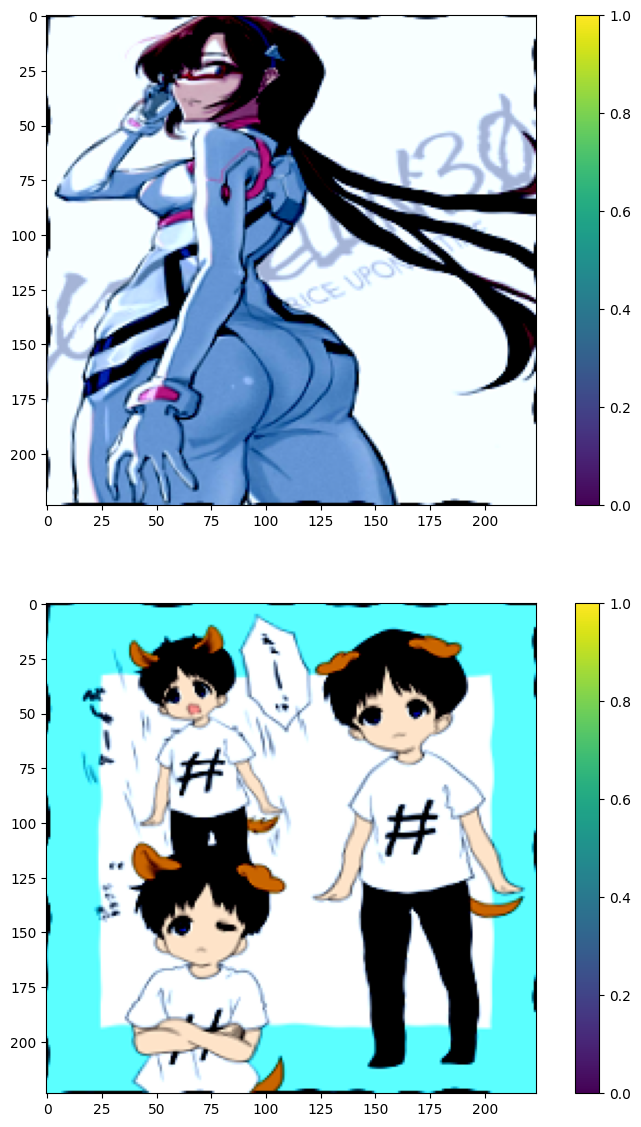

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 14))

# we assume already np.ndarray
for i in range(0, 2):
    ax = fig.add_subplot(2, 1, i+1)
    shw = plt.imshow(np.array(batch[0][i].permute(1, 2, 0).to("cpu")))
    bar = plt.colorbar(shw)
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.890523..2.448254].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0034037..1.6875494].


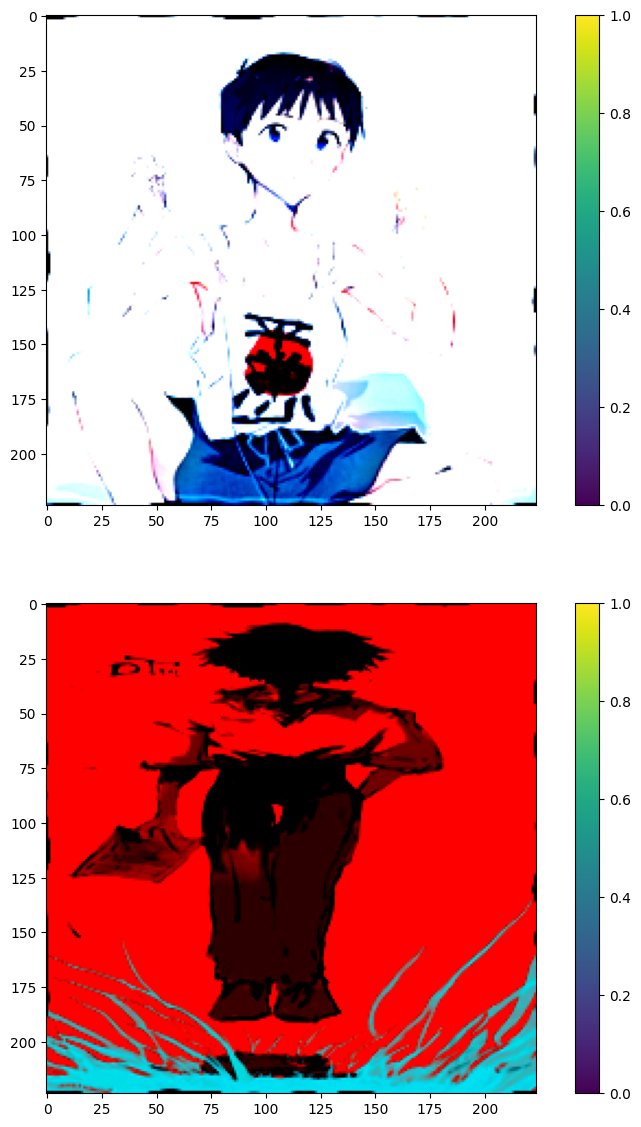

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 14))

# we assume already np.ndarray
for i in range(0, 2):
    ax = fig.add_subplot(2, 1, i+1)
    shw = plt.imshow(np.array(batch[0][i].permute(1, 2, 0).to("cpu")))
    bar = plt.colorbar(shw)
        


In [23]:
batch[0].min(), batch[0].max(), batch[0].mean(), batch[0].std()

(tensor(-2.0034, device='cuda:0'),
 tensor(2.4483, device='cuda:0'),
 tensor(0.7412, device='cuda:0'),
 tensor(1.3001, device='cuda:0'))

In [11]:
batch[0].min(), batch[0].max(), batch[0].mean(), batch[0].std()

(tensor(-1.0590, device='cuda:0'),
 tensor(1.0821, device='cuda:0'),
 tensor(-0.1235, device='cuda:0'),
 tensor(0.5596, device='cuda:0'))

In [13]:
def collate_fn(
    batch: list[np.ndarray, int],
    device: torch.device,
    transform: callable=None,
    phase: str="train") -> tuple[torch.Tensor]:
    
    batch = default_collate(batch)
    batch[0] = batch[0].to(device)
    batch[1] = batch[1].to(device)
    if transform is not None:
        batch[0] = transform(batch[0], phase)


    return batch


mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transforms = ImageTransform(mean_img = mean, std_img = std)
train_loader = DataLoader(data, batch_size=2, collate_fn=lambda batch: collate_fn(batch, conf.train.device, transforms, "train"), shuffle=True)
batch = next(iter(train_loader))

batch[0].shape, batch[1].shape

(torch.Size([2, 3, 224, 224]), torch.Size([2]))

In [14]:
batch[0].min(), batch[0].max(), batch[0].mean(), batch[0].std()

(tensor(-0.9817, device='cuda:0'),
 tensor(0.9465, device='cuda:0'),
 tensor(-0.2765, device='cuda:0'),
 tensor(0.6210, device='cuda:0'))

In [5]:
a = torch.randn((2, 16, 32))
a[:, 0].shape

torch.Size([2, 32])

# Train

In [1]:
from training import main
import omegaconf
path = "config.yaml"
conf = omegaconf.OmegaConf.load(path)

main(conf)

E:\Data\mobilenet\images\ayanami_rei/*.jpg
E:\Data\mobilenet\images\ikari_shinji/*.jpg
E:\Data\mobilenet\images\makinami_mari_illustrious/*.jpg
E:\Data\mobilenet\images\nagisa_kaworu/*.jpg
E:\Data\mobilenet\images\souryuu_asuka_langley/*.jpg


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Start training!


AttributeError: Can't pickle local object 'create_dataset.<locals>.<lambda>'